 # Training for ChessNN

### Imports

In [3]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import sys


project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.engine.evaluators.simple_nn_eval import ChessNN  # Import the model class

### Load data and set configurations

In [4]:
# Configuration
DATA_PATH = '../../data/processed/lichess_eval/lichess_processed.pt'  # From processing step
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001
PATIENCE = 5  # For early stopping
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Load processed data
data = torch.load(DATA_PATH)
inputs = data['inputs'].to(DEVICE)  # Shape: [num_samples, NUM_PLANES, 8, 8]
labels = data['labels'].to(DEVICE)  # Shape: [num_samples, 1]
print(f"Loaded {len(inputs)} samples. Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")

# Create dataset and split (80% train, 20% validation)
dataset = TensorDataset(inputs, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Using device: cpu
Loaded 99365 samples. Inputs shape: torch.Size([99365, 28, 8, 8]), Labels shape: torch.Size([99365, 1])


### Setup

In [5]:

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model, loss, optimizer
model = ChessNN().to(DEVICE)
criterion = nn.MSELoss()  # Suitable for regression
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)


### Train function

In [6]:

# Training function with early stopping
def train_model():
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []
    
    for epoch in range(EPOCHS):
        # Train
        model.train()
        train_loss = 0.0
        for batch_inputs, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validate
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_inputs, batch_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_chess_nn.pth')
            print("Saved best model.")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early stopping triggered.")
                break
    
    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

### Training

Epoch 1/50 - Validation: 100%|██████████| 311/311 [00:01<00:00, 171.58it/s]


Epoch 1: Train Loss = 0.0279, Val Loss = 0.0256
Saved best model.


Epoch 2/50 - Validation: 100%|██████████| 311/311 [00:01<00:00, 255.77it/s]


Epoch 2: Train Loss = 0.0249, Val Loss = 0.0240
Saved best model.


Epoch 3/50 - Validation: 100%|██████████| 311/311 [00:01<00:00, 304.15it/s]


Epoch 3: Train Loss = 0.0232, Val Loss = 0.0246


Epoch 4/50 - Validation: 100%|██████████| 311/311 [00:01<00:00, 285.39it/s]


Epoch 4: Train Loss = 0.0220, Val Loss = 0.0233
Saved best model.


Epoch 5/50 - Validation: 100%|██████████| 311/311 [00:01<00:00, 295.15it/s]


Epoch 5: Train Loss = 0.0205, Val Loss = 0.0232
Saved best model.


Epoch 6/50 - Validation: 100%|██████████| 311/311 [00:01<00:00, 298.60it/s]


Epoch 6: Train Loss = 0.0187, Val Loss = 0.0235


Epoch 7/50 - Validation: 100%|██████████| 311/311 [00:01<00:00, 255.54it/s]


Epoch 7: Train Loss = 0.0167, Val Loss = 0.0234


Epoch 8/50 - Validation: 100%|██████████| 311/311 [00:04<00:00, 64.21it/s]


Epoch 8: Train Loss = 0.0147, Val Loss = 0.0249


Epoch 9/50 - Validation: 100%|██████████| 311/311 [00:01<00:00, 233.44it/s]


Epoch 9: Train Loss = 0.0135, Val Loss = 0.0234


Epoch 10/50 - Validation: 100%|██████████| 311/311 [00:01<00:00, 288.09it/s]


Epoch 10: Train Loss = 0.0096, Val Loss = 0.0239
Early stopping triggered.


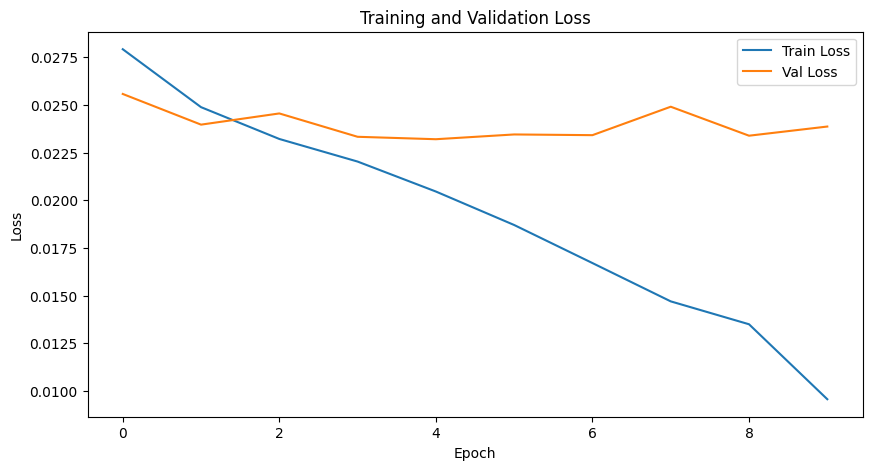

In [7]:
train_model()